## Words Analysis

This analysis examines collected text and meta-data from scientific articles that mention risk factors for violence and recidivism.

Available information includes the titles, words, and years of all those papers, enabling further exploration and analysis.


In [1]:
%matplotlib inline

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from lisc import Words
from lisc.data import ArticlesAll
from lisc.data.utils import threshold_counter, combine_lists
from lisc.utils import SCDB, load_object
from lisc.io import load_txt_file
from lisc.plts.words import plot_years, plot_wordcloud
from lisc.analysis.words import get_all_counts, get_all_values, get_attribute_counts

In [2]:
import seaborn as sns
sns.set_context('talk')

In [3]:
# Import custom project code
import sys
sys.path.append('../code')
from plts import plot_count_hist, plot_attrs_by_year

## Setup

In [4]:
# Settings
SAVE_FIG = True

In [5]:
# Set the file locations
term_dir = '../terms/'
figs_dir = '../data/figures/words'
import os
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)
from lisc.utils import SCDB
db = SCDB('../data')
#'./data/counts/counts_violence.p

In [6]:
# Set the name of the file to load
name = 'blue_health_factors'

In [7]:
print(db.get_folder_path('words'))


../data/data/words


In [10]:
# Robust loader for Words object (repo-relative, safe fallbacks)
from pathlib import Path
from lisc.utils import SCDB
from lisc.io import load_object
import pickle

# 0) Choose the label you want
name = globals().get("name", "blue_health_factors")  # or "blue_health_exposure_metrics"

# 1) Locate repo root (looks upward until finds ./data)
REPO_ROOT = Path.cwd()
while not (REPO_ROOT / "data").exists() and REPO_ROOT != REPO_ROOT.parent:
    REPO_ROOT = REPO_ROOT.parent

WORDS_DIR = REPO_ROOT / "data" / "words"
WORDS_DIR.mkdir(parents=True, exist_ok=True)

print("REPO_ROOT:", REPO_ROOT.resolve())
print("WORDS_DIR:", WORDS_DIR.resolve())
avail = sorted(p.name for p in WORDS_DIR.glob("words_*.p"))
print("Available:", avail)

# 2) Pick target file
target = WORDS_DIR / f"words_{name}.p"
if not target.exists():
    # fallback to any words_*.p
    target = next(WORDS_DIR.glob("words_*.p"), None)

if not target or not target.exists():
    raise FileNotFoundError(
        f"No words_*.p found under {WORDS_DIR}. "
        "Run scripts/collect_words.py first."
    )

print("Chosen:", target.name)

# 3) Try SCDB → plain dir → raw pickle
words = None
err_scdb = err_dir = None

try:
    db = SCDB(str(REPO_ROOT))          # SCDB root MUST be the repo root
    words = load_object(target.stem, directory=db, reload_results=True)
    print("Loaded via SCDB.")
except Exception as e:
    err_scdb = e
    try:
        words = load_object(target.stem, directory=str(WORDS_DIR), reload_results=True)
        print("Loaded via directory path.")
    except Exception as e2:
        err_dir = e2
        # Last resort: raw pickle (results may not be reloaded from raw/summary)
        with open(target, "rb") as f:
            words = pickle.load(f)
        print("Loaded via raw pickle (reload_results=False).")

# 4) Quick sanity check
print("Object type:", type(words))
try:
    print("n A labels:", len(words.terms['A'].labels))
except Exception:
    pass

# Optional: show errors from previous attempts
if err_scdb:
    print("SCDB load error:", repr(err_scdb))
if err_dir:
    print("Dir load error:", repr(err_dir))


REPO_ROOT: /Users/davidgallardo-pujol/Documents/GitHub/BlueHealthKnowledge
WORDS_DIR: /Users/davidgallardo-pujol/Documents/GitHub/BlueHealthKnowledge/data/words
Available: ['words_blue_health_factors.p', 'words_test.p']
Chosen: words_blue_health_factors.p
Loaded via raw pickle (reload_results=False).
Object type: <class 'lisc.objects.words.Words'>
SCDB load error: FileNotFoundError(2, 'No such file or directory')
Dir load error: ValueError('Can not find requested file name.')


In [11]:
import os
print(os.getcwd())


/Users/davidgallardo-pujol/Documents/GitHub/BlueHealthKnowledge/notebooks


In [12]:
# Load exclusions for analysis
from lisc.io import load_txt_file
exclusions = load_txt_file('analysis_exclusions.txt', term_dir, split_elements=False)

### Check Database Information

Check the metadata about the data collection, including checking the database data were collected from.

In [13]:
# Check database scrape info
words.meta_data.db_info

{'dbname': 'pubmed',
 'menuname': 'PubMed',
 'description': 'PubMed bibliographic record',
 'dbbuild': 'Build-2025.11.02.00.48',
 'count': '39608600',
 'lastupdate': '2025/11/02 00:48'}

In [14]:
# Check requester object info
words.meta_data.requester

{'n_requests': 5547,
 'wait_time': 0.3333333333333333,
 'start_time': '14:37:44 Sunday 02 November 2025',
 'end_time': '17:37:06 Sunday 02 November 2025',
 'logging': None}

## Data Organization

In [15]:
# Process data to collapse across all articles
words.process_combined_results(exclusions=exclusions)

### Check Number of Articles

In [16]:
# Check the number of risk factors
print('Number of risk factors: 	 {}'.format(words.n_terms))

Number of risk factors: 	 60


In [17]:
# Check the total number of articles in the collected dataset
n_articles = [data.n_articles for data in words]
total_article_count = sum(n_articles)
print('Number of articles: \t', total_article_count)

Number of articles: 	 546652


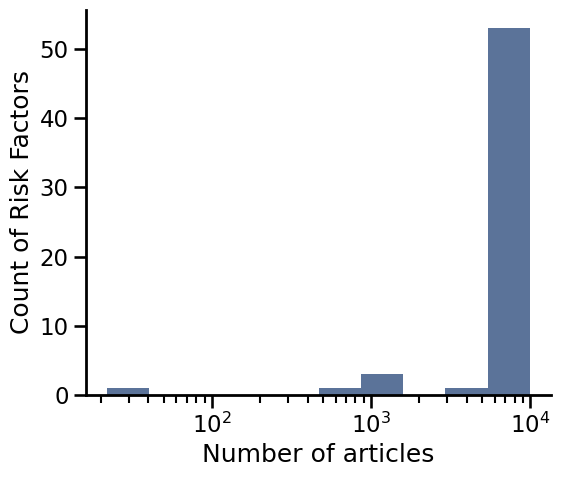

In [18]:
# Plot the histogram of the number of collected articles per risk factor
plot_count_hist(n_articles, log=True, bins=10,
                xlabel='Number of articles', ylabel='Count of Risk Factors',
                save_fig=SAVE_FIG, file_name='blue_health_factors_hist.pdf', directory=figs_dir)


In [19]:
# Collect all the DOIs across all papers, handling None values
from lisc.analysis.words import get_all_values
all_dois = get_all_values(words, 'dois')
dois = [doi for sublist in all_dois if sublist is not None for doi in sublist]
dois = list(set(dois))  # Remove duplicates



In [20]:
# Check the number of unique papers, based on DOIs
print('Number of unique DOIs:', len(dois))

Number of unique DOIs: 9009


In [21]:
# Check how many articles were found per risk factor
for data in words.results:
    print(data.label, '\t', data.n_articles)

Mental health 	 9995
Affect balance 	 9966
Psychological distress 	 9922
Perceived stress 	 9997
Anxiety 	 9983
Depression 	 9982
Rumination 	 9977
Post-traumatic stress 	 9969
Fear of water 	 22
Resilience 	 9995
Self-esteem 	 9966
Self-efficacy 	 9991
Mindfulness 	 9979
Nature connectedness 	 9983
Awe 	 9983
Attention restoration 	 1018
Sleep quality 	 9964
Social wellbeing 	 9997
Pro-environmental behavior 	 892
Cognitive function 	 9995
Executive function 	 9990
Memory 	 9976
Attention 	 9994
Creativity 	 9980
Neurocognitive development 	 9967
Headache 	 9899
Heart rate 	 9992
Blood pressure 	 9972
Cortisol 	 9946
Inflammation 	 9983
Immune function 	 9977
Endocrine markers 	 9953
Metabolic health 	 9973
Lipids 	 9972
Body mass index 	 9982
Physical activity 	 9986
Fitness 	 9992
Thermoregulation 	 9960
Respiratory symptoms 	 9940
Respiratory health 	 9929
Dermatological condition 	 9955
Otitis externa 	 4240
Gastrointestinal illness 	 9882
Infection 	 9983
Neurological condition 	

## Check Attribute Counts

In [22]:
# Define a list of attributes to check
attrs = ['words', 'keywords', 'authors', 'journals', 'dois', 'titles', 'years']

In [23]:
# Check the proportion of papers, for each attribute, that has data
from lisc.analysis.words import get_attribute_counts
print('Attribute counts (total # articles: {}):'.format(total_article_count))
for attr in attrs:
    count = get_attribute_counts(words, attr)
    print('    {:5d} articles ({:6.2f} %) have {}.'.format(\
        count, count / total_article_count * 100, attr))

Attribute counts (total # articles: 546652):
    531666 articles ( 97.26 %) have words.
    446482 articles ( 81.68 %) have keywords.
    545448 articles ( 99.78 %) have authors.
    546652 articles (100.00 %) have journals.
    538148 articles ( 98.44 %) have dois.
    546652 articles (100.00 %) have titles.
    546652 articles (100.00 %) have years.


### Check Years of Publication

In [24]:
# Get global count of authors 
years = set(get_all_values(words, 'years'))
min_year, max_year = min(years), max(years)

In [25]:
# Print out summary of the year range of publications
print('Collected papers were published between the years: {}-{}'.format(min_year, max_year))

Collected papers were published between the years: 1880-2026


In [26]:
# Get the count of articles per year, and drop 2025 (incomplete year)
from lisc.analysis.words import get_all_counts
year_counts = get_all_counts(words, 'years', combine=True)
year_counts.pop(2025);

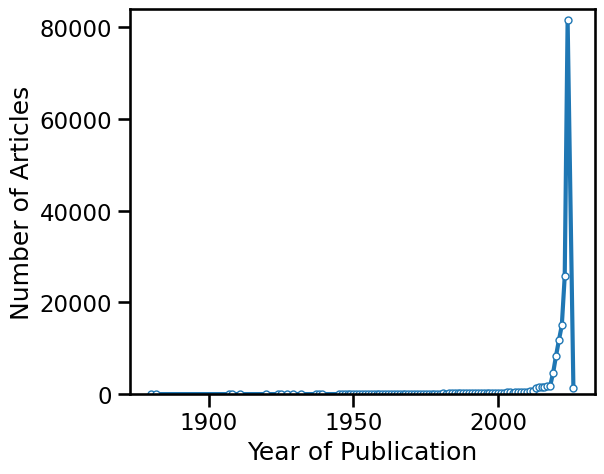

In [27]:
# Plot the total number of articles, across components, per year
plot_years(year_counts, figsize=(6, 5),
           save_fig=SAVE_FIG, file_name='words_year_counts.pdf', directory=figs_dir)

### Check number of distinct risk factors' studies per year

In [29]:
# Collect the set of years each risk factor was studied in
comp_years_all = {}
for label, res in zip(words.labels, words.results):
    comp_years_all[label] = set(res.years)

In [30]:
# Collect the number of unique components studied per year
comp_years = {}
for year in range(min(years), max(years)):
    count = 0
    for temp in comp_years_all.values():
        count += 1 if year in temp else 0
    comp_years[year] = count

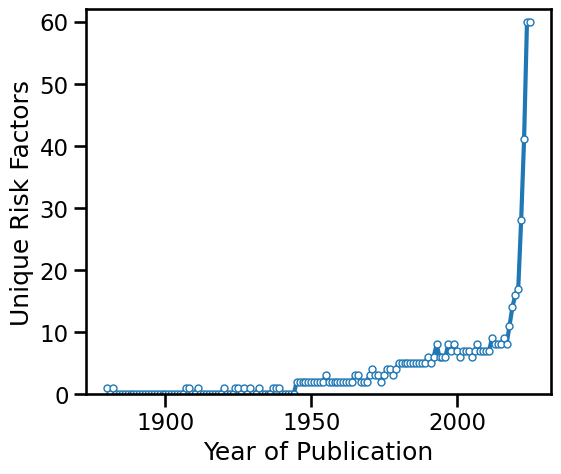

In [31]:
# Plot the number of unique components studied per year
plot_years(comp_years, ylabel='Unique Risk Factors', figsize=(6, 5),
           save_fig=SAVE_FIG, file_name='words_year_risk_factors.pdf', directory=figs_dir)

### Check Authors across all papers

In [32]:
# Get global count of authors 
author_counts = get_all_counts(words, 'authors', combine=True)

In [33]:
# Check the number of unique authors
print('Total number of authors   :\t {:5d}'.format(len(author_counts)))
print('Number of authors > 10   :\t {:5d}'.format(len(threshold_counter(author_counts, 10))))
print('Number of authors > 100  :\t {:5d}'.format(len(threshold_counter(author_counts, 100))))

Total number of authors   :	 1058599
Number of authors > 10   :	 45314
Number of authors > 100  :	  1763


In [34]:
# Check the most common authors
print('Most common authors:')
for (author, count) in author_counts.most_common(10):
    print('    {:15s} \t {}'.format(' '.join(author), count))

Most common authors:
    Wang Y          	 10578
    Zhang Y         	 9646
    Li Y            	 8657
    Liu Y           	 7288
    Wang X          	 6958
    Li J            	 6691
    Wang J          	 6409
    Li X            	 6288
    Zhang J         	 5887
    Zhang X         	 5877


### Check Journals across all papers

In [35]:
# Get global count of journals
journals_counts = get_all_counts(words, 'journals', combine=True)

In [36]:
# Check the number of unique authors
print('Total number of journals  :\t {:5d}'.format(len(journals_counts)))
print('Number of journals > 10   :\t {:5d}'.format(len(threshold_counter(journals_counts, 10))))
print('Number of journals > 100  :\t {:5d}'.format(len(threshold_counter(journals_counts, 100))))

Total number of journals  :	 10249
Number of journals > 10   :	  6062
Number of journals > 100  :	  1199


In [37]:
# Check the most common journals
print('Most common journals:')
for (journal, count) in journals_counts.most_common(10):
    print('    {:55s} \t {}'.format(journal.split(':')[0], count))

Most common journals:
    Cureus                                                  	 13588
    Scientific reports                                      	 11004
    PloS one                                                	 7501
    Frontiers in psychology                                 	 5438
    Journal of clinical medicine                            	 4843
    International journal of molecular sciences             	 3613
    Medicine                                                	 3381
    BMJ open                                                	 3367
    BMC public health                                       	 3056
    Frontiers in public health                              	 3038


### Keywords

In [38]:
# Get global count of authors 
kw_counts = get_all_counts(words, 'keywords', combine=True)

In [39]:
# Check the number of unique keywords
print('Total number of keywords   :\t {:5d}'.format(len(kw_counts)))
print('Number of keywords > 10    :\t {:5d}'.format(len(threshold_counter(kw_counts, 10))))
print('Number of keywords > 100   :\t {:5d}'.format(len(threshold_counter(kw_counts, 100))))

Total number of keywords   :	 448447
Number of keywords > 10    :	 26955
Number of keywords > 100   :	  2670


In [40]:
# Check the most common keywords across all components
print('Most common keywords:')
for (kw, count) in kw_counts.most_common(10):
    print('    {:20s} \t {}'.format(kw, count))

Most common keywords:
    depression           	 12061
    mental health        	 10033
    covid-19             	 8940
    anxiety              	 8241
    quality of life      	 8087
    meta-analysis        	 5807
    obesity              	 5496
    inflammation         	 5097
    pregnancy            	 5037
    children             	 5037


In [41]:
# Check most common keywords per risk factor
for data in words.combined_results:
    data.check_frequencies('keywords', n_check=5)

Mental health : depression, anxiety, systematic review, meta-analysis, adolescents
Affect balance : depression, anxiety, mental health, bipolar disorder, quality of life
Psychological distress : mental health, depression, anxiety, quality of life, covid-19
Perceived stress : oxidative stress, mental health, depression, inflammation, anxiety
Anxiety : depression, mental health, quality of life, stress, covid-19
Depression : anxiety, mental health, quality of life, major depressive disorder, adolescents
Rumination : covid-19, depression, anxiety, mental health, stress
Post-traumatic stress : ptsd, post-traumatic stress disorder, depression, mental health, trauma
Fear of water : swimming, mental health, health, water safety, physical education
Resilience : mental health, covid-19, depression, climate change, stress
Self-esteem : depression, mental health, quality of life, adolescents, anxiety
Self-efficacy : mental health, quality of life, physical activity, depression, social support
Min

### Abstract Words

In [42]:
# Get global count of words 
word_counts = get_all_counts(words, 'words', combine=True)

In [43]:
# Check the number of unique words
print('Total number of words   :\t {:5d}'.format(len(word_counts)))
print('Number of words > 100   :\t {:5d}'.format(len(threshold_counter(word_counts, 100))))
print('Number of words > 1000  :\t {:5d}'.format(len(threshold_counter(word_counts, 1000))))

Total number of words   :	 1329592
Number of words > 100   :	 35867
Number of words > 1000  :	  8560


In [44]:
# Check the most common keywords across all risk factors
print('Most common words:')
for (word, count) in word_counts.most_common(10):
    print('    {:20s} \t {}'.format(word, count))

Most common words:
    patients             	 694869
    study                	 568882
    p                    	 431260
    health               	 347043
    group                	 296994
    risk                 	 286080
    using                	 284171
    associated           	 274169
    treatment            	 258828
    significant          	 256996


In [45]:
# Check most common words
for data in words.combined_results:
    data.check_frequencies('words', n_check=5)

Mental health : health, patients, study, mental, quality
Affect balance : study, patients, health, symptoms, depression
Psychological distress : patients, study, health, psychological, p
Perceived stress : study, patients, p, health, using
Anxiety : study, patients, health, depression, p
Depression : health, study, symptoms, patients, anxiety
Rumination : study, anxiety, health, patients, symptoms
Post-traumatic stress : ptsd, symptoms, stress, study, health
Fear of water : water, fear, swimming, study, anxiety
Resilience : study, health, stress, psychological, support
Self-esteem : study, health, social, patients, life
Self-efficacy : study, health, intervention, patients, p
Mindfulness : study, intervention, health, stress, interventions
Nature connectedness : patients, study, p, analysis, using
Awe   : patients, study, using, treatment, p
Attention restoration : attention, directed, task, visual, study
Sleep quality : patients, study, p, quality, health
Social wellbeing : patients, 

## Check Values by Year

In [46]:
# Extract lists of all values for attributes of interest
all_years = get_all_values(words, 'years')
all_journals = get_all_values(words, 'journals')
all_authors = get_all_values(words, 'authors')

In [47]:
# Collect the number of unique journals & authors by year
journals_by_year = {}
authors_by_year = {}
for year in range(min_year, max_year):
    inds = np.where(np.array(all_years) == year)[0]
    journals_by_year[year] = len(set(np.array(all_journals)[inds]))
    authors_by_year[year] = len(set(combine_lists([all_authors[ind] for ind in inds])))

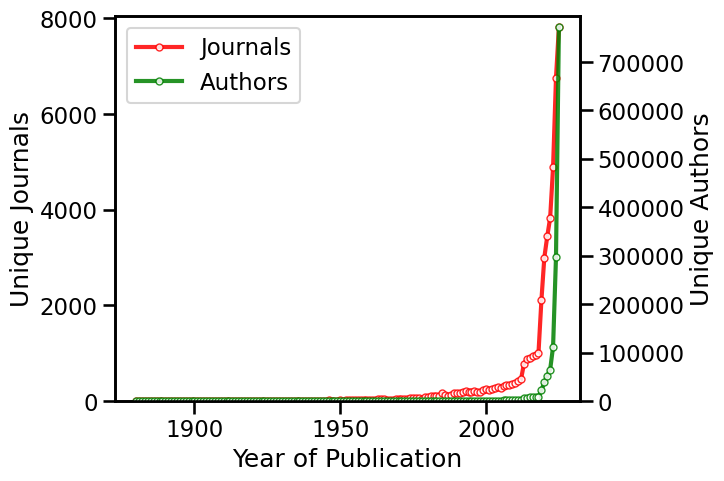

In [48]:
# Plot unique journals & authors by year
plot_attrs_by_year(journals_by_year, authors_by_year, figsize=(6, 5),
                   save_fig=SAVE_FIG, file_name='words_attr_year.pdf', directory=figs_dir)

## Example Risk Factor Summaries

In [55]:
# Set indices for some example risk factors
inds = [12, 10]
print(words.labels[inds[0]], words.labels[inds[1]])

Mindfulness Self-esteem


In [56]:
# Check some example summaries
for ind in inds:
    words.combined_results[ind].create_summary()
    words.combined_results[ind].print_summary()

Mindfulness :
  Number of articles: 		 9979
  First publication: 		 2019
  Most common author: 		 Li Y
    number of publications: 	 95
  Most common journal: 		 Frontiers in psychology
    number of publications: 	 583 

Self-esteem :
  Number of articles: 		 9966
  First publication: 		 2018
  Most common author: 		 Wang Y
    number of publications: 	 74
  Most common journal: 		 Frontiers in psychology
    number of publications: 	 520 



### WordCloud Plots

In [61]:
import sys; print(sys.executable)
# Try import; if missing, install into the current kernel, then import.
try:
    from lisc.plts.words import plot_wordcloud
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud", "pillow"])
    from lisc.plts.words import plot_wordcloud


/Users/davidgallardo-pujol/Documents/GitHub/BlueHealthKnowledge/.venv/bin/python


In [63]:
def plot_wordcloud_safe(freq_dist, n_words, ax):
    try:
        from lisc.plts.words import plot_wordcloud
        return plot_wordcloud(freq_dist, n_words, ax=ax)
    except Exception:
        # Fallback: bar chart of top terms
        items = sorted(freq_dist.items(), key=lambda x: -x[1])[:n_words]
        words_, freqs = zip(*items) if items else ([], [])
        ax.bar(range(len(freqs)), freqs)
        ax.set_xticks(range(len(words_)))
        ax.set_xticklabels(words_, rotation=60, ha='right')
        ax.set_ylabel("freq")
        ax.set_title("Top terms (fallback)")


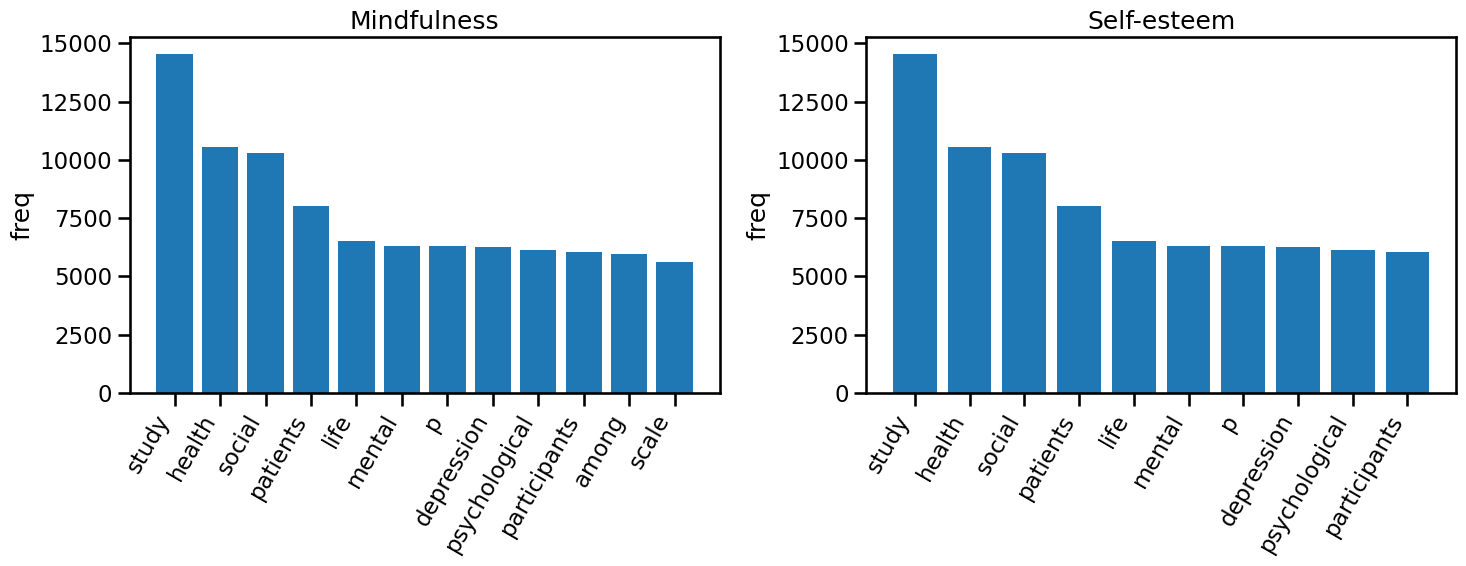

In [65]:
_, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_wordcloud_safe(words.combined_results[ind].words, inds[0], ax=axes[0])
axes[0].set_title(words.labels[inds[0]])
plot_wordcloud_safe(words.combined_results[ind].words, inds[1], ax=axes[1])
axes[1].set_title(words.labels[inds[1]])
plt.tight_layout()


### History Plots

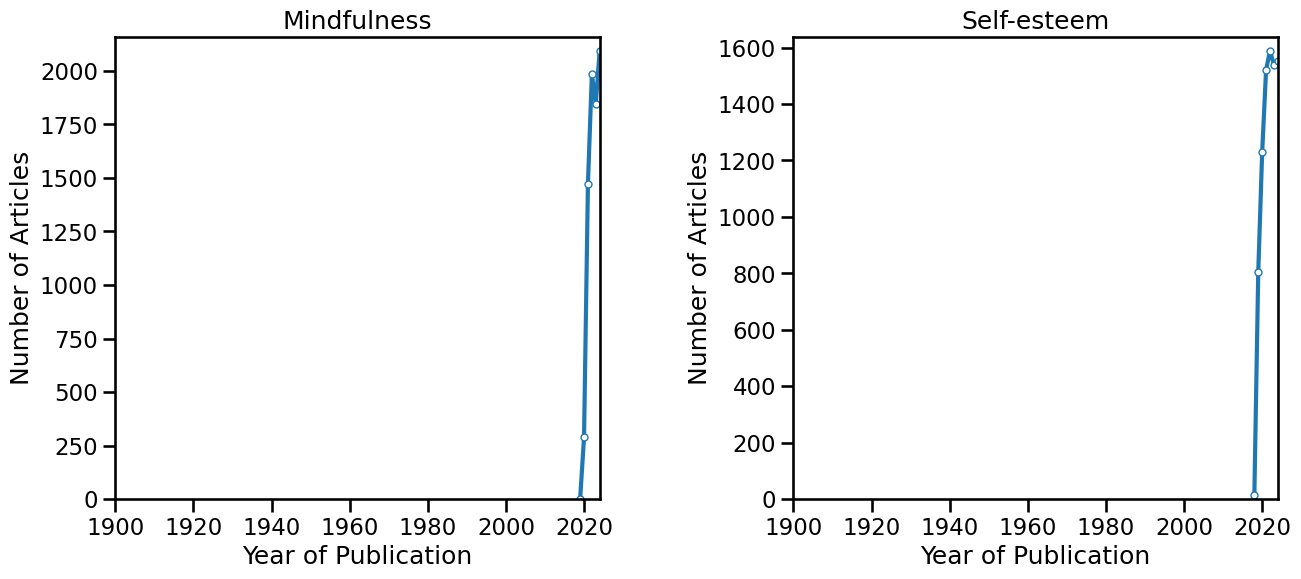

In [66]:
# Check an example history plot



import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plt.subplots_adjust(wspace=0.4)  # Augmenta l'espai horitzontal entre els gràfics

plot_years(words.combined_results[inds[0]].years, [None, 2024], ax=axes[0])
axes[0].set_title(words.labels[inds[0]]);

plot_years(words.combined_results[inds[1]].years, [None, 2024], ax=axes[1])
axes[1].set_title(words.labels[inds[1]]);

import numpy as np

# Set x-axis limits for both subplots
axes[0].set_xlim(1900, 2024);
axes[1].set_xlim(1900, 2024);

# Define tick marks every 20 years (adjust as needed)
ticks = np.arange(1900, 2024, 20);
axes[0].set_xticks(ticks);
axes[1].set_xticks(ticks);

